## Magic The Gathering card prices: a time series analysis

 

I'll start with a disclaimer: I am not a big Magic The Gathering (MTG) fan myself, but my wife is one and I know how to play <strike>(with my white weenie deck)</strike>. Most importantly, for a long time I have been fascinated with the idea of MTG cards as financial instruments - although crypto-instruments might be a better word in this case. Those who are new to MTG can check out websites like <a href="https://www.mtgstocks.com/news">mtgstocks.com</a> to see that they do not look much different from Yahoo.Finance. MTG fans are not strangers to <a href="https://www.reddit.com/r/mtgfinance/comments/6vnm73/mtg_and_financial_derivatives/">conversations about financial derivatives</a> and <a href="https://magic.wizards.com/en/articles/archive/official-reprint-policy-2010-03-10">emission policy</a>. All in all, it does seem like an interesting playground - even more so because of abundance of available data.

In this notebook (which is still a work in progress), I am exploring a small dataset with some card price time series. The data was supposed to include all Mythic Rare cards at the time when I obtained it, but it is likely that the actual list has expanded since then. The credit for the data goes to the above mentioned MTGStocks. Since my goal in this project is just self-education, I will not be publishing the dataset itself but please see the accompanying notebook on this repo for the scraping code.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
data = pd.read_csv("mtg_mythic.csv")
print(data.shape)
print(data['card'].nunique())
data.info()

(371649, 3)
952
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371649 entries, 0 to 371648
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card    371649 non-null  object 
 1   date    371649 non-null  object 
 2   price   371649 non-null  float64
dtypes: float64(1), object(2)
memory usage: 8.5+ MB


As I mentioned above, the dataset is pretty simple. There are 952 unique cards, a date of measurement, and an average market price of the card on that date. The prices are measured on a weekly basis. For some cards, the series is as long as 8 years (approximately 2012-2020). Let us look at one of them - the infamous <a href="https://www.mtgstocks.com/prints/15770-black-lotus">Black Lotus</a>. If you are still in doubt - yes, the price on the y-axis is in U.S. dollars.

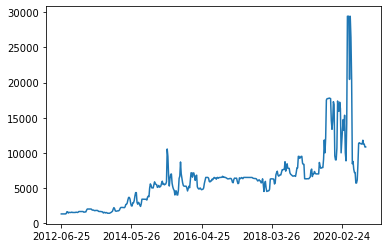

In [2]:
x1 = list(data[data['card'] == "Black Lotus"]['price'])
x2 = list(data[data['card'] == "Black Lotus"]['date'])
bl = pd.DataFrame(x1, index = x2)
bl.plot.line(legend = False)

The spike in early 2020 looks interesting. <a href="https://us.forums.blizzard.com/en/wow/t/black-lotus-price-watch/539106">Allegedly</a>, it happened because of some collectors selling off their cards en masse. How do we start analyzing this from a pure data perspective, though? Each time series usually can be decomposed into three distinct components - the long-term trend, seasonal pattern, and residual noise. Understanding the shapes of these three components is often the first step in time series analysis.

Unfortunately, it is not possible to make this decomposition without any prior assumptions which often require some domain knowledge. In our case, we know that Wizards of the Coast, the company behind MTG, releases several new card sets each year. Since each release can potentially generate powerful combinations with earlier released cards (this is a vast topic of its own and my knowledge of it, unfortunately, is rather sub-par) for competitive players, you might expect price movements after each new release. Let us assume for now that the series is seasonal at quarterly level (13 weeks).

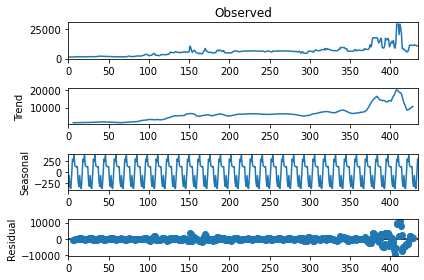

In [3]:
subset = data[data['card'] == "Black Lotus"]
series = subset['price'].values
result = seasonal_decompose(series, model = 'additive', period = 13)
result.plot()
plt.show()

Note that the trend follows the original complete series rather closely until we reach the later period which seem to be mostly dominated by noise.

Possibly due to my lack of experience with this, I am not sure how to interpret the seasonality part - that is, except for saying that this component is present in our data. However, I <a href="https://otexts.com/fpp2/seasonal-strength.html">found</a> an objective measure - strength of seasonality - which may be useful for confirming whether my choice of expecting 13-week seasonality from this data is correct. The basic idea is to check whether the variance of the original series is primarily determined by the variance of its seasonal component or by the variance of the trend component.

The code below estimates the powers of seasonality and trend for each of the cards in my data at different periodicities, from 2 to 200 weeks. Note that I am also looking only at additive decomposition for now.

In [4]:
# get card list
list1 = list(data['card'].values)
list2 = []
for i in list1:
    if i not in list2:
        list2.append(i)
        
# get average powers of trend and seasonality        
ind = []
trend_powers = []
season_powers = []

for x in range(2, 201):
    trend_f = []
    season_f = []
    
    for i in list2:
        subset = data[data['card'] == i]
        series = subset['price'].values
        
        # seasonality
        try:
            result = seasonal_decompose(series, model = 'additive', period = x)
            output = max(0, np.nanvar(result.resid)/(np.nanvar(result.seasonal) + np.nanvar(result.resid)))
            season_f.append(output)        
        except ValueError:
            pass
        
        # trend
        try:
            result = seasonal_decompose(series, model = 'additive', period = x)
            output = max(0, np.nanvar(result.resid)/(np.nanvar(result.trend) + np.nanvar(result.resid)))
            trend_f.append(output)
        except ValueError:
            pass

    ind.append(x)
    trend_powers.append(np.mean(trend_f))
    season_powers.append(np.mean(season_f))

As you can see from the plot of average powers below, the choice actually makes sense. Indeed, seasonality is strongest when the periodicity is assumed to low. When periodicity is increased, the power of trend becomes more and more prominent.

This is it for now. My plan for this analysis is to have more practice with standard time series methods and to develop predictive models for some price series. I am also thinking about coming up with a way to predict a measure of how synergy between cards affects their prices. I am not completely sure what would be a best methodological approach for this as of right now but we'll see.

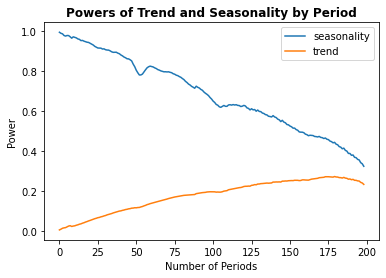

In [5]:
ind_s = pd.DataFrame(ind)
trend_powers_s = pd.Series(trend_powers)
season_powers_s = pd.Series(season_powers)
comparison = pd.concat((ind_s, trend_powers_s), axis = 1 )
comparison = pd.concat((comparison, season_powers_s), axis = 1)
comparison.columns = ['cadence', 'trend', 'seasonality']
comparison['seasonality'].plot.line()
comparison['trend'].plot.line()
plt.legend(loc='upper right')
plt.title("Powers of Trend and Seasonality by Period", fontsize = 12, fontweight = 'bold')
plt.xlabel("Number of Periods")
plt.ylabel("Power")
plt.show()

In [6]:
###WORK IN PROGRESS###